In [1]:
import numpy as np
import time
import os

%load_ext autoreload
%autoreload 2
# most important script - relevance estimator
from prediction_difference_analysis import PredDiffAnalyser

# utilities
import utils_classifiers as utlC
import utils_data as utlD
import utils_sampling as utlS
import utils_visualise as utlV

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm

In [2]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.softmax(x)

In [3]:
netpath = 'mnist_model.pt'
netname = 'mnist'
path_data = './test_data'
classnames = list(map(str, range(0, 10)))

# pick for which layers the explanations should be computed
# (names depend on network, output layer is usually called '-1')
layer_numbers = [-1]

# is torch running in gpu mode?
gpu = False

# pick image indices which are analysed (in alphabetical order as in the ./data folder) [0,1,2,...]
# (if None, all images in './data' will be analysed)
test_indices = 0

# window size (i.e., the size of the pixel patch that is marginalised out in each step)
win_size = 5               # k in alg 1 (see paper)

# indicate whether windows should be overlapping or not
overlapping = True

# settings for sampling 
sample_style = 'conditional' # choose: conditional / marginal
num_samples = 10
padding_size = 3            # important for conditional sampling,
                            # l = win_size+2*padding_size in alg 1
                            # (see paper)

# set the batch size - the larger, the faster computation will be
batch_size = 64


# ------------------------ SET-UP ------------------------

net = utlC.get_net(netpath)

utlC.set_torch_mode(net, gpu=gpu)

# get the data
transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

X_test, X_test_im, X_filenames = utlD.get_data(path_data, transformation)

image_dims = X_test_im[0].shape

if not test_indices:
    test_indices = [i for i in range(len(X_test))]      

# make folder for saving the results if it doesn't exist
path_results = './results/'
if not os.path.exists():
    os.makedirs(path_results)          
          
# ------------------------ EXPERIMENTS ------------------------

# target function (mapping input features to output probabilities)
target_func = lambda x: utlC.forward_pass(net, x, layer_numbers, gpu)

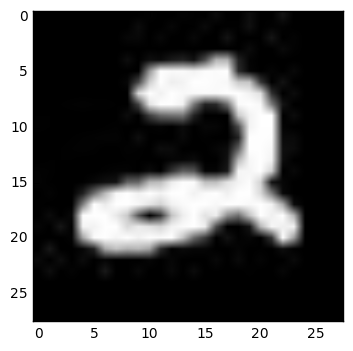

In [4]:
plt.imshow(X_test_im[0], cmap='gray')

In [5]:
image_dims = X_test_im[0].shape

In [6]:
if sample_style == 'conditional':
    sampler = utlS.cond_sampler(X=X_test, win_size=win_size, padding_size=padding_size,
                                         image_dims=image_dims, netname=netname)
elif sample_style == 'marginal':
    sampler = utlS.marg_sampler(X_test, net)
    
for test_idx in test_indices:
      
    # get the specific image (preprocessed, can be used as input to the target function)
    x_test = X_test[test_idx]
    # get the image for plotting (not preprocessed)
    x_test_im = X_test_im[test_idx]
    # prediction of the network
    y_pred = np.argmax(utlC.forward_pass(net, x_test, [-1], gpu)[0][0].data.numpy())
    y_pred_label = y_pred
                 
    print("doing test...", "file :", X_filenames[test_idx], ", net:", netpath, ", win_size:", win_size,
          ", sampling: ", sample_style)

doing test... file : img_1 , net: mnist_model.pt , win_size: 5 , sampling:  conditional
doing test... file : img_2 , net: mnist_model.pt , win_size: 5 , sampling:  conditional
doing test... file : img_3 , net: mnist_model.pt , win_size: 5 , sampling:  conditional
doing test... file : img_4 , net: mnist_model.pt , win_size: 5 , sampling:  conditional
doing test... file : img_5 , net: mnist_model.pt , win_size: 5 , sampling:  conditional
doing test... file : img_6 , net: mnist_model.pt , win_size: 5 , sampling:  conditional


In [18]:
pda = PredDiffAnalyser(X_test[0], target_func, sampler, num_samples=num_samples, batch_size=batch_size)
pred_diff = pda.get_rel_vect(win_size=win_size, overlap=overlapping)

row 0/24 took: --- 0.1371 seconds --- 
row 1/24 took: --- 0.2490 seconds --- 
row 2/24 took: --- 0.2507 seconds --- 
row 3/24 took: --- 0.2573 seconds --- 
row 4/24 took: --- 0.2271 seconds --- 
row 5/24 took: --- 0.2879 seconds --- 
row 6/24 took: --- 0.2893 seconds --- 
row 7/24 took: --- 0.1518 seconds --- 
row 8/24 took: --- 0.1450 seconds --- 
row 9/24 took: --- 0.2960 seconds --- 
row 10/24 took: --- 0.2648 seconds --- 
row 11/24 took: --- 0.1843 seconds --- 
row 12/24 took: --- 0.2243 seconds --- 
row 13/24 took: --- 0.3118 seconds --- 
row 14/24 took: --- 0.3122 seconds --- 
row 15/24 took: --- 0.2968 seconds --- 
row 16/24 took: --- 0.3021 seconds --- 
row 17/24 took: --- 0.3453 seconds --- 
row 18/24 took: --- 0.3022 seconds --- 
row 19/24 took: --- 0.3056 seconds --- 
row 20/24 took: --- 0.1614 seconds --- 
row 21/24 took: --- 0.2828 seconds --- 
row 22/24 took: --- 0.1762 seconds --- 
row 23/24 took: --- 0.2247 seconds --- 


In [19]:
prd = pred_diff[0].reshape((image_dims[0],image_dims[1],-1))

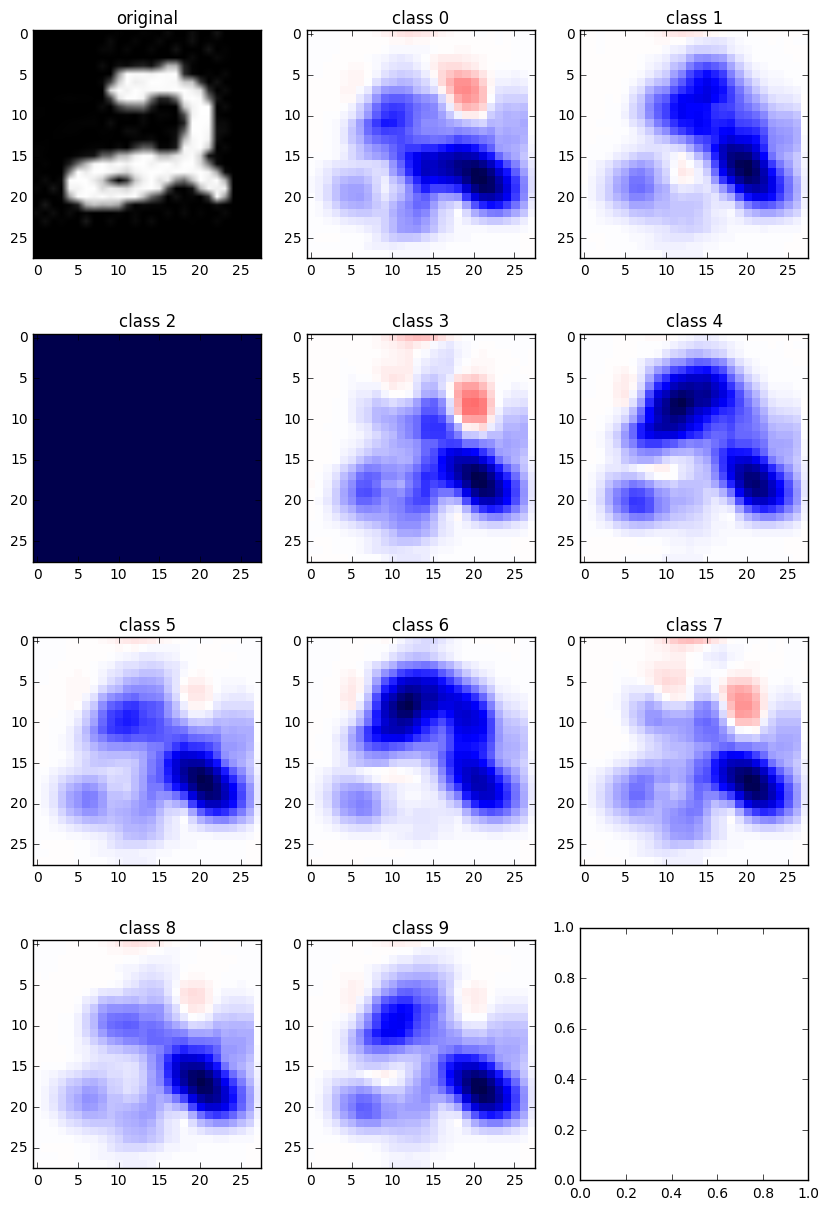

In [20]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,15))

plt.subplot(4, 3, 1)
plt.title('original')
plt.imshow(X_test_im[0], cmap='gray')

for i in range(1, 6):
    plt.subplot(4, 3, 2*i)
    plt.title('class {}'.format(2*i-2))
    p = prd[:,:,2*(i-1)]
    plt.imshow(p, cmap=cm.seismic, vmin=-np.max(np.abs(p)), vmax=np.max(np.abs(p)), interpolation='nearest')
    
    plt.subplot(4, 3, 2*i+1)
    plt.title('class {}'.format(2*i-1))
    p = prd[:,:,2*(i-1)+1]
    plt.imshow(p, cmap=cm.seismic, vmin=-np.max(np.abs(p)), vmax=np.max(np.abs(p)), interpolation='nearest')

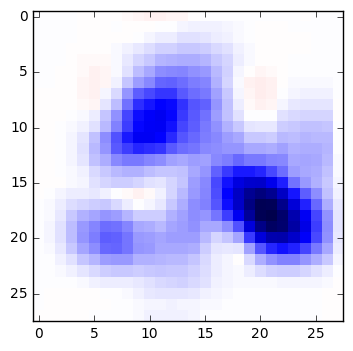

In [21]:
p = pred_diff[0].reshape((image_dims[0],image_dims[1],-1))[:, :,9]
plt.imshow(p, cmap=cm.seismic, vmin=-np.max(np.abs(p)), vmax=np.max(np.abs(p)), interpolation='nearest')

In [22]:
pda = PredDiffAnalyser(X_test[2], target_func, sampler, num_samples=num_samples, batch_size=batch_size)
pred_diff = pda.get_rel_vect(win_size=win_size, overlap=overlapping)

row 0/24 took: --- 0.3683 seconds --- 
row 1/24 took: --- 0.3951 seconds --- 
row 2/24 took: --- 0.3267 seconds --- 
row 3/24 took: --- 0.2324 seconds --- 
row 4/24 took: --- 0.3460 seconds --- 
row 5/24 took: --- 0.4169 seconds --- 
row 6/24 took: --- 0.3001 seconds --- 
row 7/24 took: --- 0.1157 seconds --- 
row 8/24 took: --- 0.1547 seconds --- 
row 9/24 took: --- 0.1799 seconds --- 
row 10/24 took: --- 0.3076 seconds --- 
row 11/24 took: --- 0.3008 seconds --- 
row 12/24 took: --- 0.2216 seconds --- 
row 13/24 took: --- 0.1579 seconds --- 
row 14/24 took: --- 0.2507 seconds --- 
row 15/24 took: --- 0.3750 seconds --- 
row 16/24 took: --- 0.2115 seconds --- 
row 17/24 took: --- 0.1291 seconds --- 
row 18/24 took: --- 0.2874 seconds --- 
row 19/24 took: --- 0.2986 seconds --- 
row 20/24 took: --- 0.4599 seconds --- 
row 21/24 took: --- 0.5040 seconds --- 
row 22/24 took: --- 0.4149 seconds --- 
row 23/24 took: --- 0.3194 seconds --- 


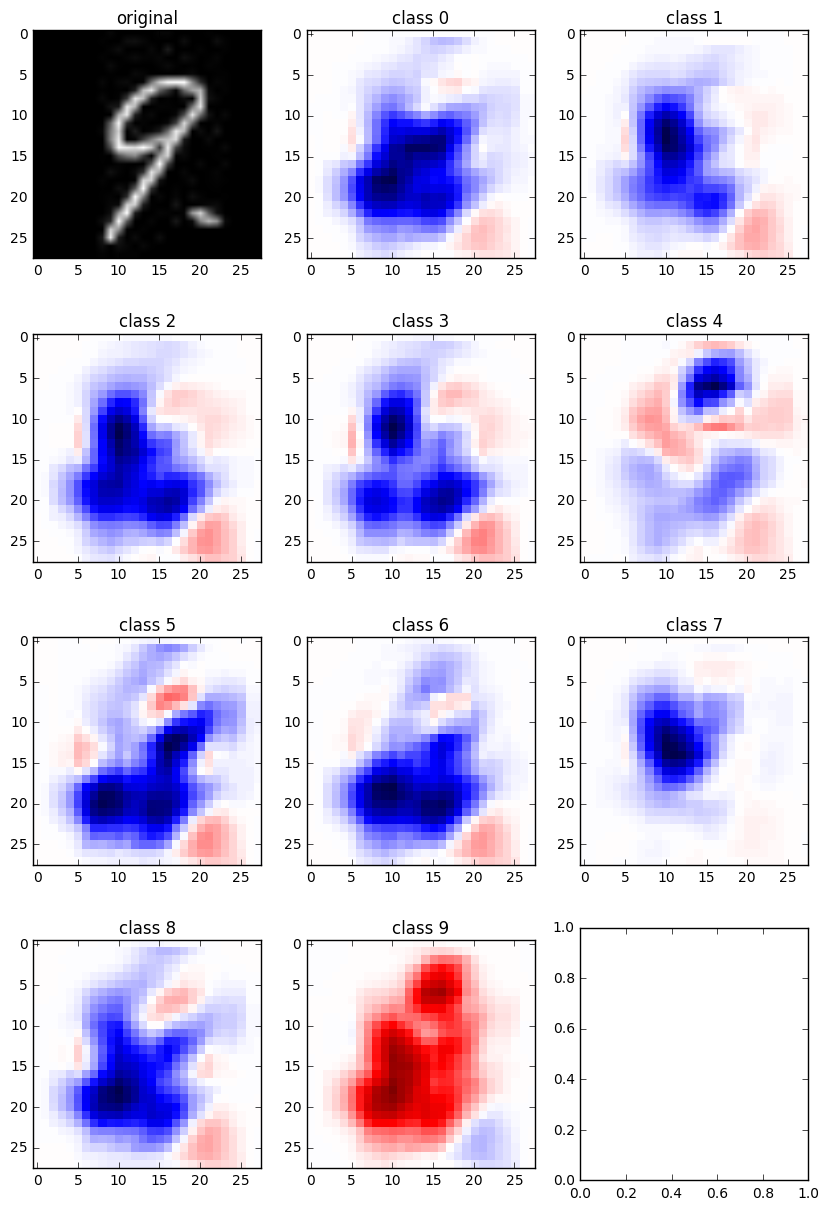

In [23]:
prd = pred_diff[0].reshape((image_dims[0],image_dims[1],-1))

fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(10,15))

plt.subplot(4, 3, 1)
plt.title('original')
plt.imshow(X_test_im[2], cmap='gray')

for i in range(1, 6):
    plt.subplot(4, 3, 2*i)
    plt.title('class {}'.format(2*i-2))
    p = prd[:,:,2*(i-1)]
    plt.imshow(p, cmap=cm.seismic, vmin=-np.max(np.abs(p)), vmax=np.max(np.abs(p)), interpolation='nearest')
    
    plt.subplot(4, 3, 2*i+1)
    plt.title('class {}'.format(2*i-1))
    p = prd[:,:,2*(i-1)+1]
    plt.imshow(p, cmap=cm.seismic, vmin=-np.max(np.abs(p)), vmax=np.max(np.abs(p)), interpolation='nearest')

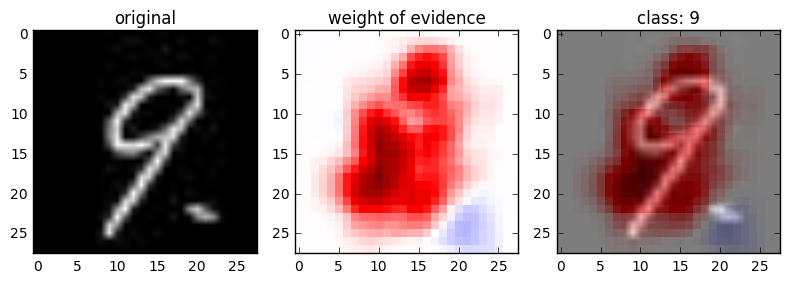

In [24]:
utlV.plot_results(X_test[2], X_test_im[2], pred_diff[0], target_func, classnames, None)

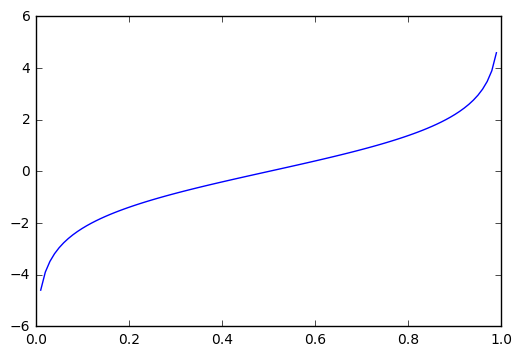

In [14]:
f = lambda x: np.log(x/(1-x))
x = np.linspace(0.01, 0.99, 100)
plt.plot(x, f(x))